# 🏆 VLM: Usage
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/1337-Artificial-Intelligence/hackai-2025/blob/main/notebooks/vlm/vlm_usage.ipynb)

## Introduction

### 📌 What are Vision Language Models & How do they work?

Vision language models are multimodal AI systems built by combining a large language model (LLM) with a vision encoder, giving the LLM the ability to **“see.”**

Most VLMs follow an architecture with three parts (as shown in the image below):

- A vision encoder is a transformer architecture that has been trained on millions of image-text pairs, giving it the ability to associate images and text.
- A projector is a set of layers that translates the output of the vision encoder into a form the LLM can understand, often interpreted as image tokens.
- An LLM, which can be any LLM that has already been trained and released.

<p align="center" >
  <img src="https://www.nvidia.com/en-us/glossary/vision-language-models/_jcr_content/root/responsivegrid/nv_container_copy_co_300503066/nv_image.coreimg.svg/1736168815674/vlm-architecture-diagram.svg" width="500" title="VLM Components"/>
</p>

### 📌 What Are the Capabilities of Vision-Language Models?
VLM can perform various tasks such as chatting about images, image recognition via instructions, visual question answering, document understanding, and more — some of which we'll explore in this challenge.
The image below showcases the different tasks a VLM can perform.


<p align="center" >
  <img src="https://cdn.prod.website-files.com/6479eab6eb2ed5e597810e9e/67ed59567624cf7b802b88a2_6687a8f8ecade4efd45a3cf6_Vision%2520Model_fig1.png" width="700" title="VLM Components"/>
</p>

Alright, enough talk — let’s mess around with these VLMs and see what they do! 🤖🎉

## Use Cases of VLMs

### Environment setup

In [ ]:
!pip install transformers -q

In [ ]:
# After you finish testing each VLM, we will use the following function to free up GPU memory and remove variables from the global scope
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

### 1. Visual Question Answering
- Goal: Answer questions about an image or video.
- Input: Image or video + a natural language question
- Output: Short natural language answer

We'll use `Qwen2-VL-2B-Instruct`.

In [ ]:
from PIL import Image
import requests
import torch
from torchvision import io
from typing import Dict
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

# First, let's load the model and its processor on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

#### Let's test with images

The image shows a meal consisting of a tagine, a traditional dish from Morocco. The tagine is filled
with a variety of vegetables, including carrots, zucchini, and possibly other vegetables. The dish
is served in a clay pot, which is a common cooking vessel in many Middle Eastern cuisines. The
tagine is placed on a white plate with a colorful place mat. In the background, there are small
bowls containing olives and bread, suggesting that this meal is part of a larger dining experience.


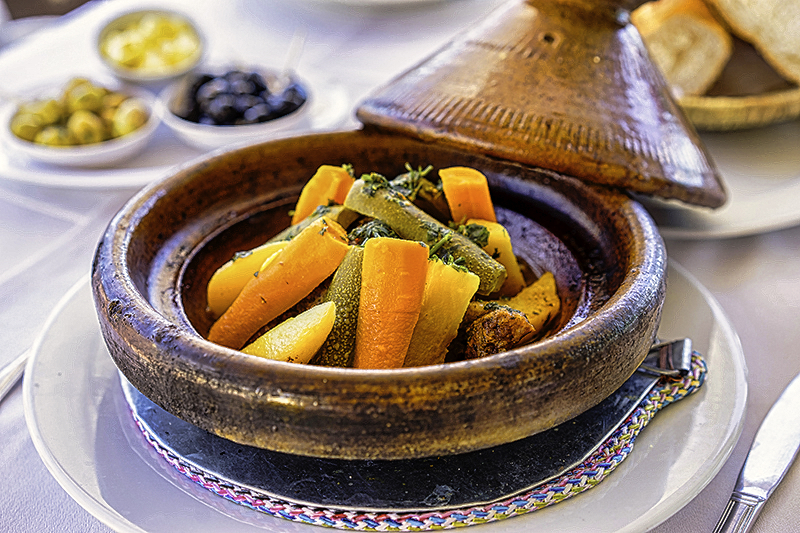

In [ ]:
# Image (Try other images)
url = "https://legarconboucher.com/img/cms/Recette/tajine-maroc.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Prompt (Try with other questions; Darija maybe?)
text_query = "What do you see in the image?"

# Define model chat template
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": text_query},
        ],
    }
]


# Preprocess the inputs
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)

import textwrap
print(textwrap.fill(output_text[0], width=100))

image

#### Let's test with videos

In [ ]:
!pip install pyav yt-dlp qwen-vl-utils

In [ ]:
def download_video(video_url: str):
  import yt_dlp

  download_folder = "/content/"

  ydl_opts = {
      'outtmpl': f'{download_folder}/video.mp4',
      'format': 'best',
  }

  with yt_dlp.YoutubeDL(ydl_opts) as ydl:
      ydl.download([video_url])

In [ ]:
download_video("https://www.youtube.com/shorts/po8D2FUCtu0")

[youtube] Extracting URL: https://www.youtube.com/shorts/po8D2FUCtu0
[youtube] po8D2FUCtu0: Downloading webpage
[youtube] po8D2FUCtu0: Downloading tv client config
[youtube] po8D2FUCtu0: Downloading tv player API JSON
[youtube] po8D2FUCtu0: Downloading ios player API JSON
[youtube] po8D2FUCtu0: Downloading m3u8 information
[info] po8D2FUCtu0: Downloading 1 format(s): 18
[download] Destination: /content//video.mp4
[download] 100% of  622.56KiB in 00:00:00 at 2.03MiB/s   


In [ ]:
from qwen_vl_utils import process_vision_info


# Video
video = "/content/video.mp4"
text_query = "What do you see in the video?"

# Messages containing a video and a text query
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "video",
                "video": video,
                "max_pixels": 360 * 420,
                "fps": 1.0,
            },
            {"type": "text", "text": text_query},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_text[0]


qwen-vl-utils using torchvision to read video.


'In the video, a man is holding a bucket filled with blue liquid. He talks to the camera and then shows the liquid to the camera.'

In [ ]:
# Ensure that you have finished testing the VLM before calling this function.
clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 4.55 GB


### 2. Image Captioning

- Goal: Generate a sentence that describes the entire image.
- Input: An image
- Output: A natural language description

Unlike VQA, which answers specific questions, image captioning gives a general overview of the image.
We'll use `blip-image-captioning-base`.

In [ ]:
import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

# First, let's load the model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16).to("cuda")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Conditional image captioning:  a photography of a woman and her dog on the beach
unconditional image captioning:  a woman sitting on the beach with her dog


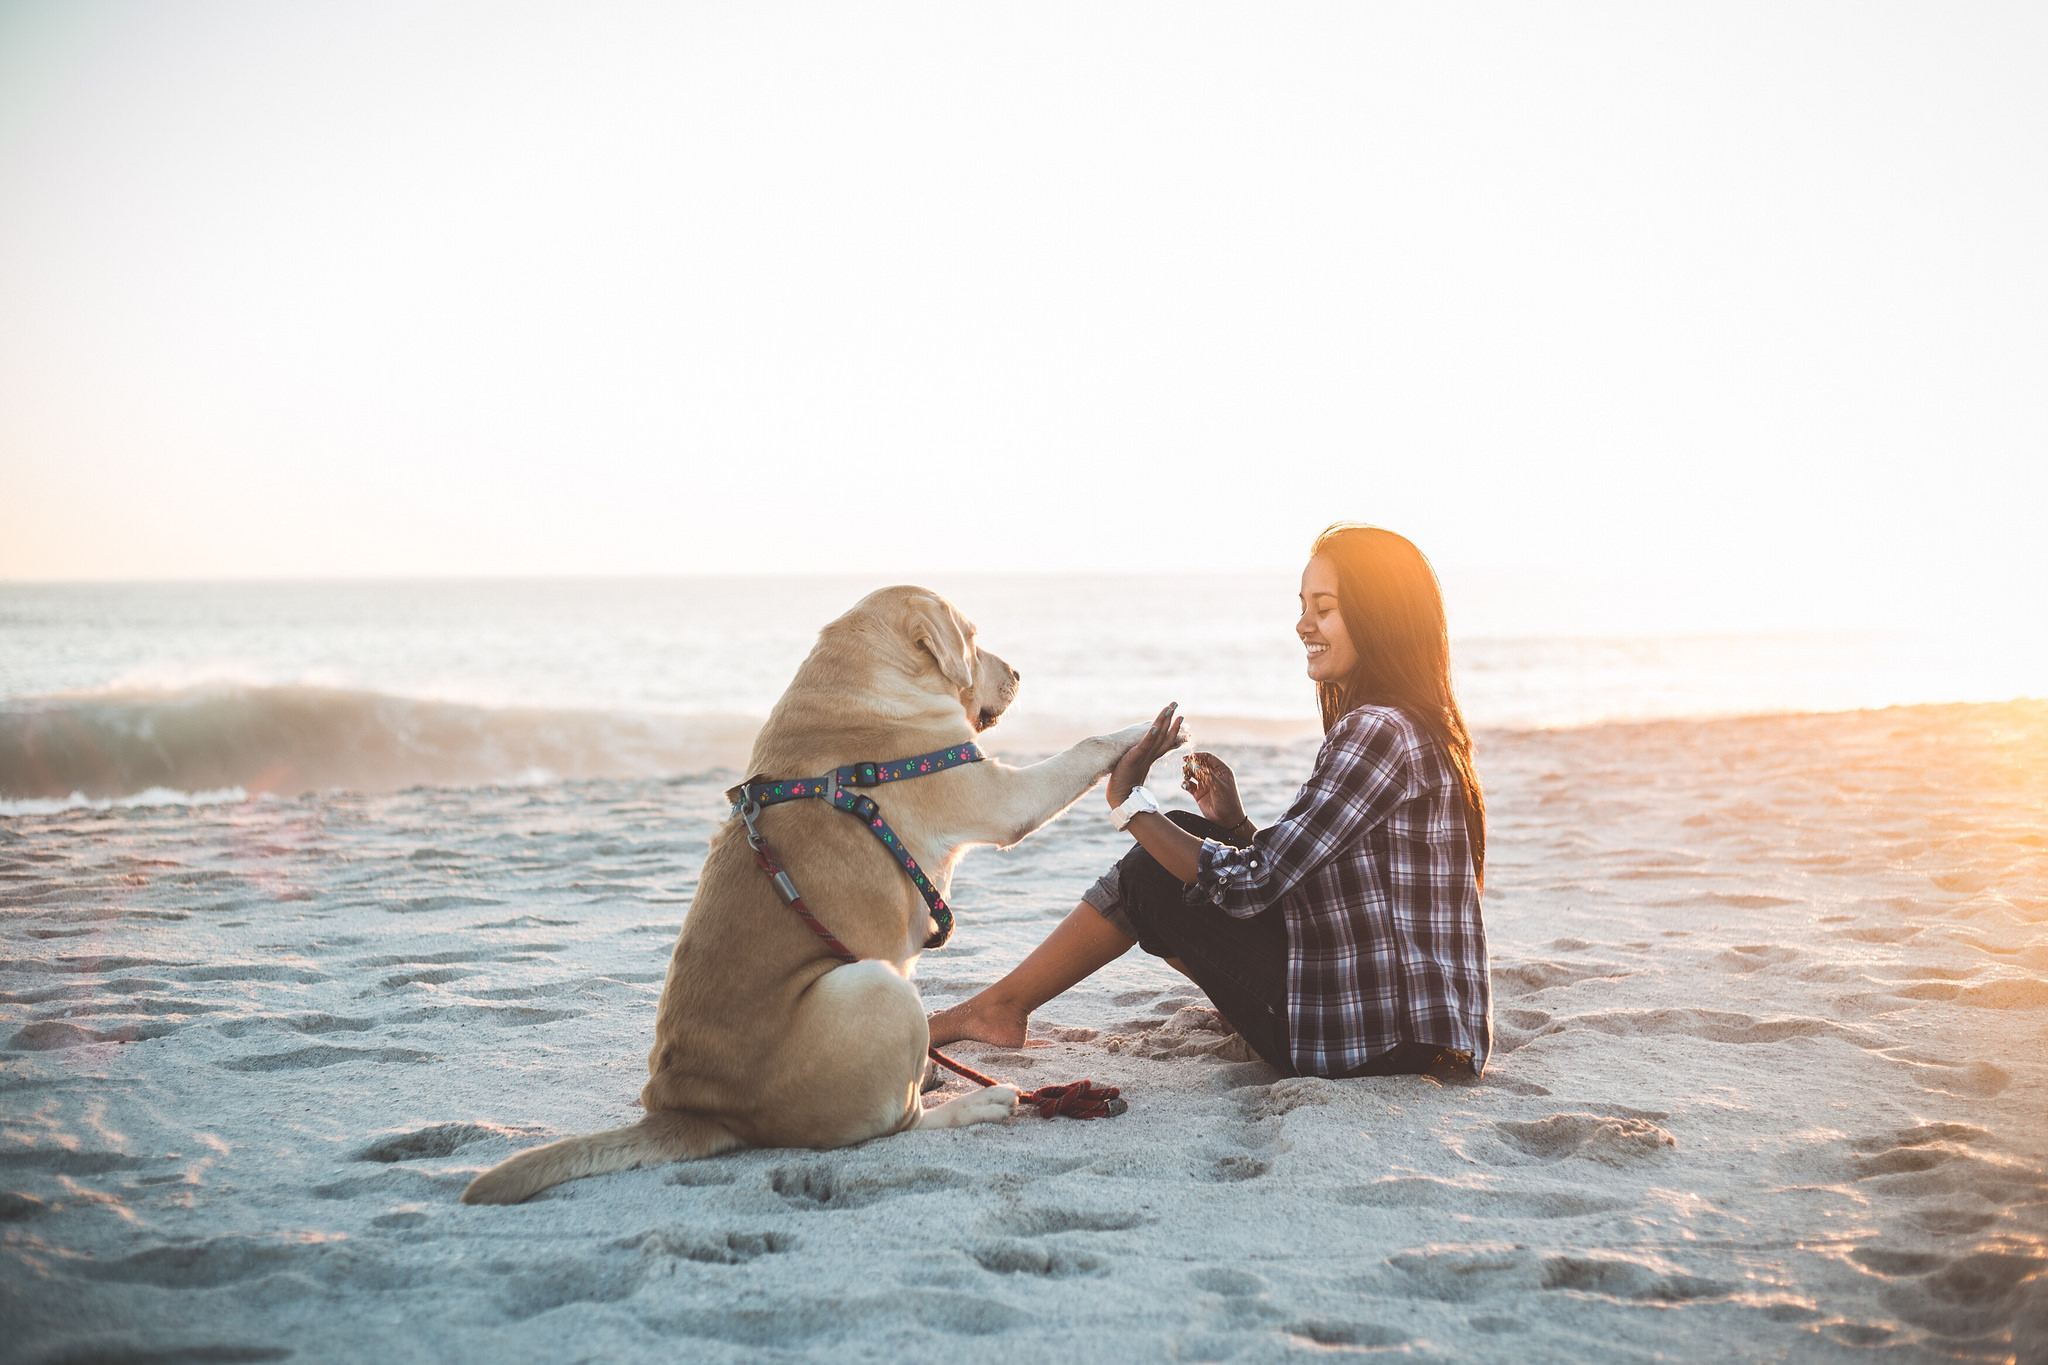

In [ ]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

# conditional image captioning (generates a caption based on an additional condition or query that guides the captioning process)
text = "a photography of"
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print("Conditional image captioning: ", processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning (generates a caption for an image without any specific context other than the image itself.)
inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print("unconditional image captioning: ", processor.decode(out[0], skip_special_tokens=True))

raw_image

In [ ]:
clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 4.55 GB


### 3. OCR (Optical Character Recognition)
- Goal: Extract text from images (printed, handwritten, or scene text).
- Input: An image with optional prompts like “Extract the invoice number.”
- Output: Transcribed, machine-readable text.

We'll use `Qwen2-VL-OCR-2B-Instruct`.

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# First, let's load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "prithivMLmods/Qwen2-VL-OCR-2B-Instruct", torch_dtype="auto", device_map="auto"
)
processor = AutoProcessor.from_pretrained("prithivMLmods/Qwen2-VL-OCR-2B-Instruct")

The name of the invoice's sender is Ted's Small
Business.<|im_end|>


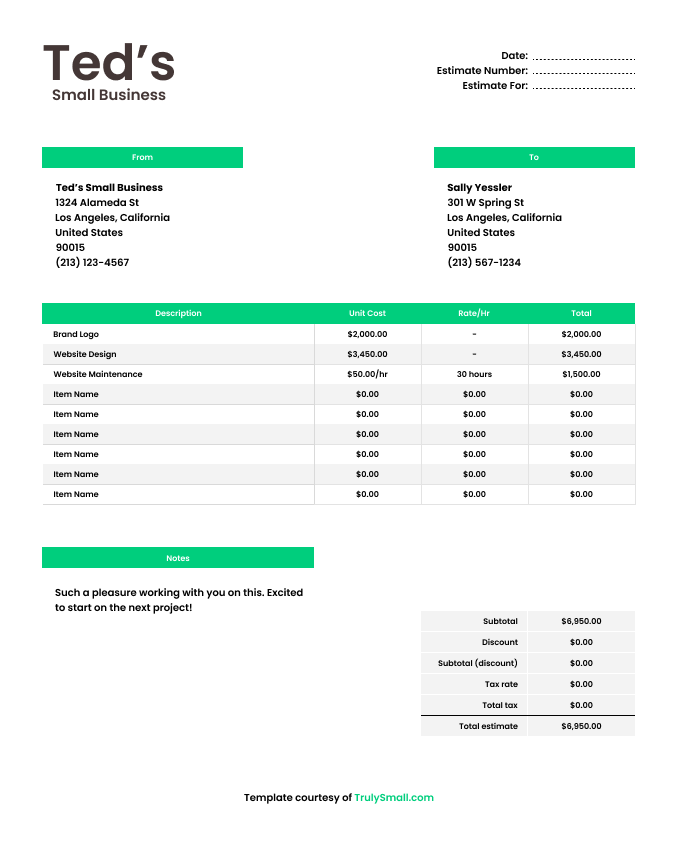

In [ ]:
# Image
url = "https://trulysmall.com/wp-content/uploads/2023/04/Simple-Invoice-Template.png"
image = Image.open(requests.get(url, stream=True).raw)

text_query = "What is the name of the invoice' sender?"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {"type": "text", "text": text_query},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

import textwrap
print(textwrap.fill(output_text[0], width=50))

image

In [ ]:
clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 4.55 GB


### 4. Visual Grounding
- Goal: Locate objects or regions in an image based on a text query.
- Input: An image and a natural language instruction (e.g., “Find the red car”).
- Output:

  - Bounding Box (e.g., [x_min, y_min, x_max, y_max]), or

  - Segmentation Mask, or

  - Object Label (e.g., “cat”, “tree”).

We'll use `microsoft/kosmos-2-patch14-224` for this task.

In [ ]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq

# First, let's load the model and its processor
model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224", device_map="auto")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")

In [ ]:
# let's define a function to run a prompt.

def run_example(prompt, image):

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = inputs.to("cuda")
    generated_ids = model.generate(
      pixel_values=inputs["pixel_values"],
      input_ids=inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      image_embeds=None,
      image_embeds_position_mask=inputs["image_embeds_position_mask"],
      use_cache=True,
      max_new_tokens=128,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    _processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
    processed_text, entities = processor.post_process_generation(generated_text)

    return processed_text, entities

In [ ]:
# Let's define a function to draw the bounding boxes returned by the VLM.
# REMARK >> (IT'S A QUITE LONG FUNCTION NO NEED TO UNDERSTAND EVERY DETAIL, Haha!)

import cv2
import numpy as np
import os
import requests
import torch
import torchvision.transforms as T

from PIL import Image


def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)


def draw_entity_boxes_on_image(image, entities, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)

    return pil_image # new_image

In [ ]:
# Test with other images

# url = "https://huggingface.co/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
url = "https://cdn.nba.com/manage/2021/12/USATSI_15452777-scaled-e1639236310885-784x462.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# Define the prompt and call the model

prompt = "<grounding> Describe this image in detail:"
model_output, entities = run_example(prompt, image)

Describe this image in detail: Two basketball players are on the court, with one of them holding a basketball and the other one trying to block him. They are both wearing blue uniforms.
[('Two basketball players', (31, 53), [(0.078125, 0.046875, 0.671875, 0.984375), (0.515625, 0.046875, 0.921875, 0.984375)]), ('the court', (61, 70), [(0.015625, 0.015625, 0.984375, 0.984375)]), ('a basketball', (97, 109), [(0.640625, 0.734375, 0.765625, 0.921875)]), ('blue uniforms', (171, 184), [(0.109375, 0.203125, 0.421875, 0.703125), (0.515625, 0.203125, 0.921875, 0.984375)])]


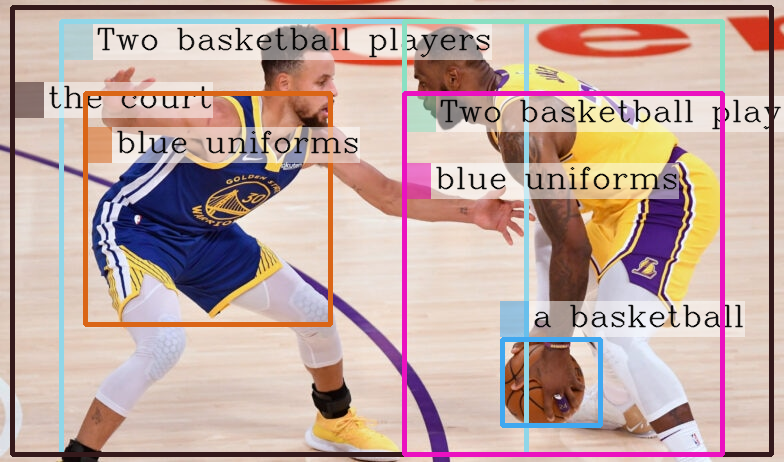

In [ ]:
# Draw the bounding boxes on the image and print the model output
new_image = draw_entity_boxes_on_image(image, entities)
print(model_output, entities, sep="\n")
new_image

In [ ]:
clear_memory()

## Example of VLM Datasets

Here are examples of datasets for each task above:

- Visual Question Answering (VQA): [DOC-VQA](https://huggingface.co/datasets/cmarkea/doc-vqa) – is a multilingual (English & French) visual question answering (VQA) dataset focused on document images.

- Image Captioning: [MS COCO Captions](https://huggingface.co/datasets/clip-benchmark/wds_mscoco_captions) – A dataset with images and captions for each image.

- Optical Character Recognition (OCR): [OCR-VQA](https://huggingface.co/datasets/howard-hou/OCR-VQA/viewer/default/train?row=0) – designed for OCR-based VQA. It focuses on understanding and answering questions about text present in images, particularly book covers.

- Visual Grounding: [Flickr30k_Grounding_Som](https://huggingface.co/datasets/Rajarshi-Roy-research/Flickr30k_Grounding_Som/viewer/default/train?row=4&views%5B%5D=train) – Links phrases in image captions to corresponding regions in the image with bounding boxes.

## Challenge

- **What other vision-language tasks can you think of?**
(Think about how VLMs could be applied in new or unusual ways.)

**Good luck with the rest of the challenge—and HAVE FUN! 🚀**
____